In [67]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 1.89 ms, sys: 3.06 ms, total: 4.95 ms
Wall time: 4.21 ms


True

In [71]:
df_order_info_details = pd.read_csv(config.processed_dir / "order_info_details.csv")
df_reviews = pd.read_csv(
    config.interim_dir
    / "olist_order_reviews_translated_label_review_categories_merged.csv",
)
df_reviews_last = df_reviews.groupby("order_id").last().reset_index()
df_order_info_details_reviews_merged = pd.merge(
    df_order_info_details, df_reviews_last, on="order_id", how="left"
)
assert df_order_info_details_reviews_merged.shape[0] == df_order_info_details.shape[0]
for col in [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date",
]:
    df_order_info_details_reviews_merged[col] = pd.to_datetime(
        df_order_info_details_reviews_merged[col],
        format="mixed",
    )
df_review_no_null = df_order_info_details_reviews_merged.dropna(
    subset=["review_comment_message_en"]
)
print(f"df_review_no_null.shape: {df_review_no_null.shape}")


df_review_no_null.shape: (40818, 90)


In [4]:
df_review_no_null.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_purchase_month', 'order_purchase_date', 'order_purchase_weekday',
       'order_approved_month', 'order_approved_date', 'order_approved_weekday',
       'order_delivered_carrier_month', 'order_delivered_carrier_weekday',
       'order_delivered_customer_month', 'order_delivered_customer_weekday',
       'order_estimated_delivery_month', 'order_estimated_delivery_weekday',
       'is_delivery_to_customers_delayed', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'total_payment_value', 'payment_type_count', 'most_common_payment_type',
       'highest_value_payment_type', 'highest_payment_value',
       'geolocation_state', 'geolocation_zip_code_prefix', 'customer_lat',
       'customer_lng', 'shipping_limit_date', 's

In [74]:
df_review_about_delivery = df_review_no_null[
    [
        "order_id",
        "product_category_name_english",
        "review_categories_str",
        # 決済承認
        "order_approved_span_hours_from_purchase",
        # 全体の予想と現実
        "order_estimated_delivery_span_hours_from_purchase",
        "order_delivered_customer_span_hours_from_purchase",
        # 販売業者→配送業者
        "order_delivered_carrier_span_hours_from_approval",
        "order_shipping_limit_span_hours_from_purchase",
        # 配送業者→顧客
        "order_estimated_delivery_span_hours_from_shipping_limit",
        "order_delivered_customer_span_hours_from_carrier",
    ]
].query("review_categories_str in ['Delivery_Issue','Delivery_Praise']")

In [75]:
print("予想")
df_review_about_delivery.groupby("review_categories_str").agg(
    {
        "order_estimated_delivery_span_hours_from_purchase": "mean",
        "order_shipping_limit_span_hours_from_purchase": "mean",
        "order_estimated_delivery_span_hours_from_shipping_limit": "mean",
    }
)


予想


,order_estimated_delivery_span_hours_from_purchase,order_shipping_limit_span_hours_from_purchase,order_estimated_delivery_span_hours_from_shipping_limit
review_categories_str,,,
Delivery_Issue,604.492826,170.398967,435.762524
Delivery_Praise,563.878956,154.407390,409.371646


In [ ]:
print("実際")
df_review_about_delivery.groupby("review_categories_str").agg(
    {
        "order_approved_span_hours_from_purchase": "mean",
        "order_delivered_customer_span_hours_from_purchase": "mean",
        "order_delivered_carrier_span_hours_from_approval": "mean",
        "order_delivered_customer_span_hours_from_carrier": "mean",
    }
)

実際


,order_approved_span_hours_from_purchase,order_delivered_customer_span_hours_from_purchase,order_delivered_carrier_span_hours_from_purchase,order_delivered_customer_span_hours_from_carrier
review_categories_str,,,,
Delivery_Issue,12.356038,580.406563,116.227214,462.253785
Delivery_Praise,10.183448,240.281657,65.901053,174.356590


In [79]:
# 実際の時間のデータを長形式に変換
df_melted_actual = df_review_about_delivery.melt(
    id_vars=["review_categories_str"],
    value_vars=[
        "order_approved_span_hours_from_purchase",
        "order_delivered_carrier_span_hours_from_approval",
        "order_delivered_customer_span_hours_from_carrier",
        "order_delivered_customer_span_hours_from_purchase",
    ],
)

# 予想時間のデータを長形式に変換
df_melted_estimated = df_review_about_delivery.melt(
    id_vars=["review_categories_str"],
    value_vars=[
        "order_shipping_limit_span_hours_from_purchase",
        "order_estimated_delivery_span_hours_from_shipping_limit",
        "order_estimated_delivery_span_hours_from_purchase",
    ],
)

# 変数名を日本語に変換するディクショナリ
var_names_actual = {
    "order_approved_span_hours_from_purchase": "購入から\n決済承認までの時間",
    "order_delivered_carrier_span_hours_from_approval": "決済承認から\n配送業者の配送までの時間",
    "order_delivered_customer_span_hours_from_carrier": "配送業者から\n顧客までの配送時間",
    "order_delivered_customer_span_hours_from_purchase": "購入から\n配送完了までの時間",
}

var_names_estimated = {
    "order_shipping_limit_span_hours_from_purchase": "購入から\n出荷期限までの時間",
    "order_estimated_delivery_span_hours_from_shipping_limit": "出荷期限から\n配送完了までの予想時間",
    "order_estimated_delivery_span_hours_from_purchase": "購入から\n配送完了までの予想時間",
}
# 変数名を日本語に変換
df_melted_actual["variable"] = df_melted_actual["variable"].map(var_names_actual)
df_melted_estimated["variable"] = df_melted_estimated["variable"].map(
    var_names_estimated
)

# hueの順序を設定
hue_order = ["Delivery_Praise", "Delivery_Issue"]

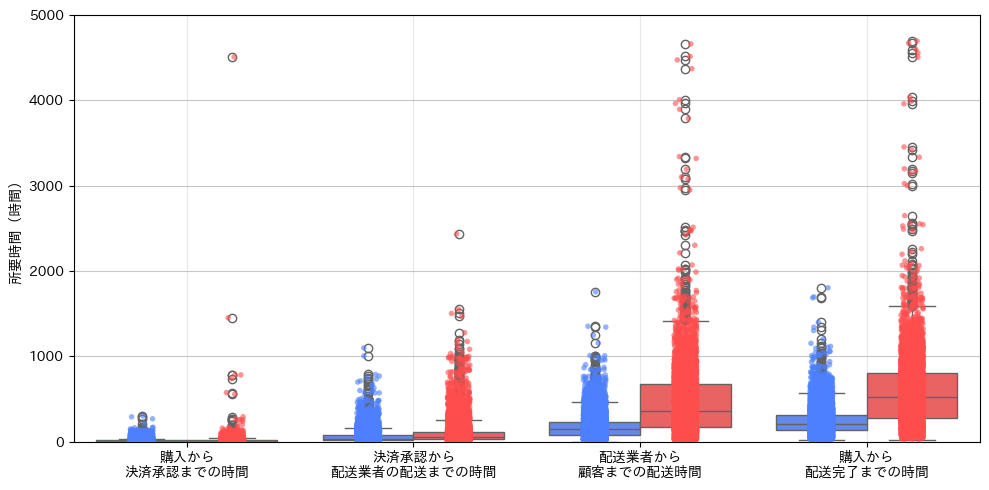

In [83]:
# サブプロットを作成（実際の時間と予想時間を分けて表示）
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# 薄い色を設定
light_blue = (0.3, 0.5, 1.0, 0.6)  # 薄い青
light_red = (1.0, 0.3, 0.3, 0.6)  # 薄い赤
sns.boxplot(
    data=df_melted_actual,
    x="variable",
    y="value",
    hue="review_categories_str",
    hue_order=hue_order,  # 順序を指定
    palette={"Delivery_Praise": light_blue, "Delivery_Issue": light_red},
    width=0.8,
    ax=ax,
    legend=False,
)

sns.stripplot(
    data=df_melted_actual,
    x="variable",
    y="value",
    hue="review_categories_str",
    hue_order=hue_order,  # 順序を指定
    dodge=True,
    # alpha=0.1,
    size=4,
    palette={"Delivery_Praise": light_blue, "Delivery_Issue": light_red},
    # palette={"Delivery_Praise": "blue", "Delivery_Issue": "red"},
    ax=ax,
    legend=False,
)
# ax.set_title("実際の配送時間の分布比較")
ax.set_xlabel("")
ax.set_ylabel("所要時間（時間）")
ax.grid(axis="x", linestyle="-", alpha=0.3)
ax.grid(axis="y", linestyle="-", alpha=0.7)

# 凡例の設定（順序を変更）
# ax.legend()
# y軸の範囲を設定
ax.set_ylim(0, 5000)
# レイアウトの調整
plt.tight_layout()
# プロットの表示
plt.show()

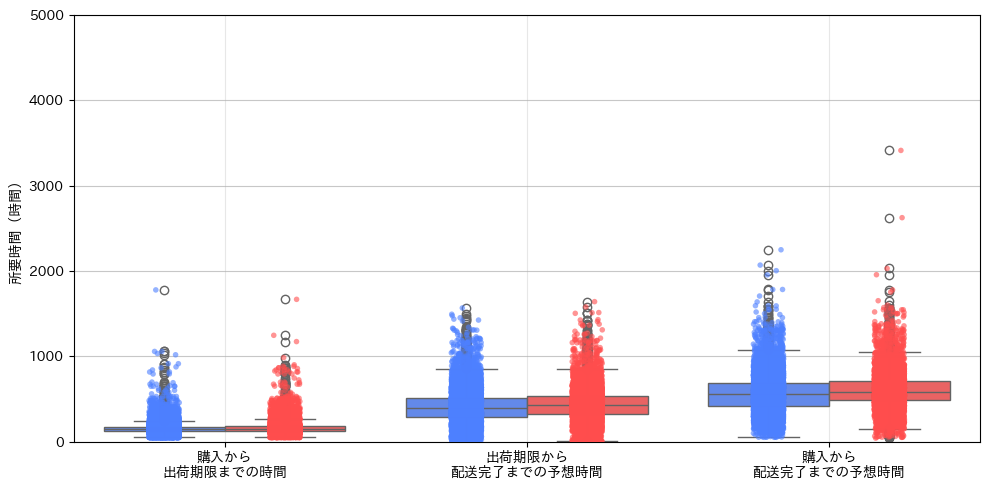

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# 薄い色を設定
light_blue = (0.3, 0.5, 1.0, 0.6)  # 薄い青
light_red = (1.0, 0.3, 0.3, 0.6)  # 薄い赤
# 予想時間のプロット
sns.boxplot(
    data=df_melted_estimated,
    x="variable",
    y="value",
    hue="review_categories_str",
    palette={"Delivery_Praise": light_blue, "Delivery_Issue": light_red},
    hue_order=hue_order,  # 順序を指定
    width=0.8,
    ax=ax,
    legend=False,  # 凡例を非表示に
)

sns.stripplot(
    data=df_melted_estimated,
    x="variable",
    y="value",
    hue="review_categories_str",
    hue_order=hue_order,  # 順序を指定
    dodge=True,
    # alpha=0.2,
    size=4,
    palette={"Delivery_Praise": light_blue, "Delivery_Issue": light_red},
    # palette={"Delivery_Praise": "blue", "Delivery_Issue": "red"},
    ax=ax,
    legend=False,
)
# ax.set_title("予想配送時間の分布比較")
ax.set_xlabel("")

ax.set_ylabel("所要時間（時間）")
ax.grid(axis="x", linestyle="-", alpha=0.3)
ax.grid(axis="y", linestyle="-", alpha=0.7)
# ax.legend()
ax.set_ylim(0, 5000)
# レイアウトの調整
plt.tight_layout()

# プロットの表示
plt.show()